Training with learning rate = 0.01
Training with learning rate = 0.001
Training with learning rate = 0.0001


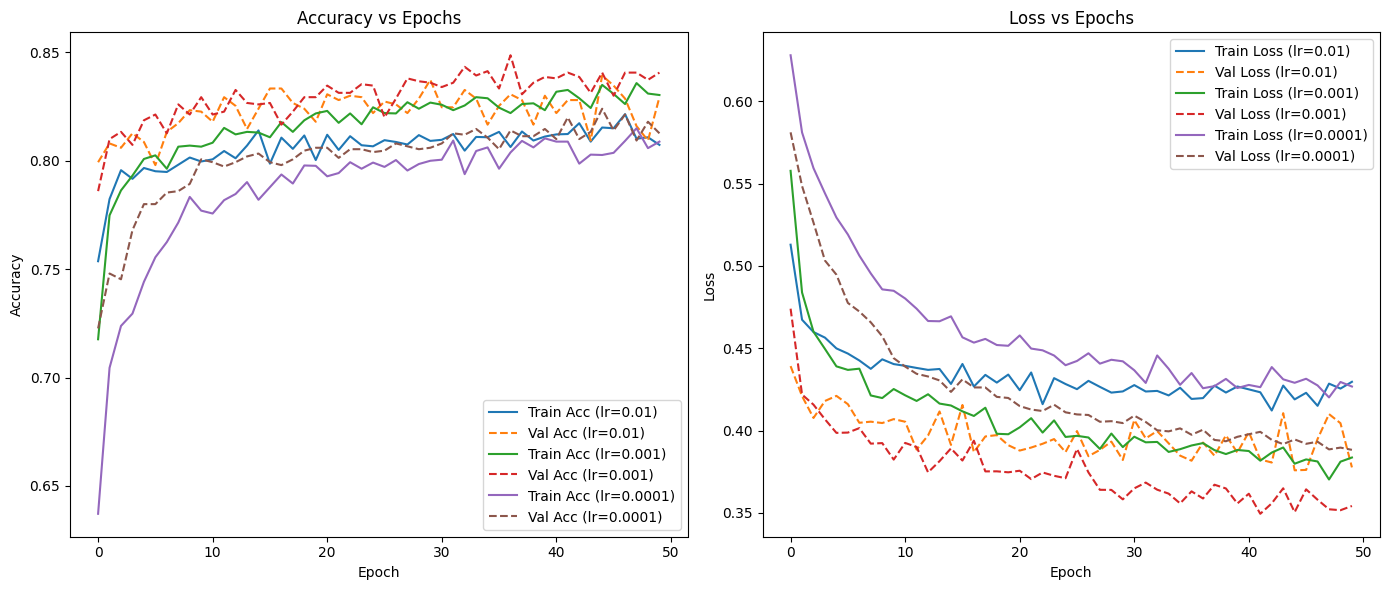

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --------------------------
# Configuration
# --------------------------
RANDOM_STATE = 42
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 50  # shorter for quick testing
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# Load Data
# --------------------------
data = pd.read_csv("Latest_features.csv")

X = data.drop('Label', axis=1)
y = data['Label']
X = X.drop(X.columns[0], axis=1)
X = X.iloc[:, :44]

y_encoded = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --------------------------
# Define Model
# --------------------------
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FeedForwardNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]
num_classes = len(np.unique(y_encoded))

# --------------------------
# Function to train and evaluate model with given LR
# --------------------------
def train_evaluate(lr):
    model = FeedForwardNN(input_dim, num_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        correct, total = 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_running_loss = 0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_running_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == y_batch).sum().item()
                val_total += y_batch.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    return train_accuracies, val_accuracies, train_losses, val_losses

# --------------------------
# Run experiments for different learning rates
# --------------------------
learning_rates = [0.01, 0.001, 0.0001]

results = {}

for lr in learning_rates:
    print(f"Training with learning rate = {lr}")
    train_acc, val_acc, train_loss, val_loss = train_evaluate(lr)
    results[lr] = {
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_loss": train_loss,
        "val_loss": val_loss,
    }

# --------------------------
# Plot results
# --------------------------
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
for lr in learning_rates:
    plt.plot(results[lr]['train_acc'], label=f'Train Acc (lr={lr})')
    plt.plot(results[lr]['val_acc'], '--', label=f'Val Acc (lr={lr})')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
for lr in learning_rates:
    plt.plot(results[lr]['train_loss'], label=f'Train Loss (lr={lr})')
    plt.plot(results[lr]['val_loss'], '--', label=f'Val Loss (lr={lr})')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
